In [1]:
!pip install fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.13.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


core           INFO 	Loading data for Italian Grand Prix - Practice 2 [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Italian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for sess

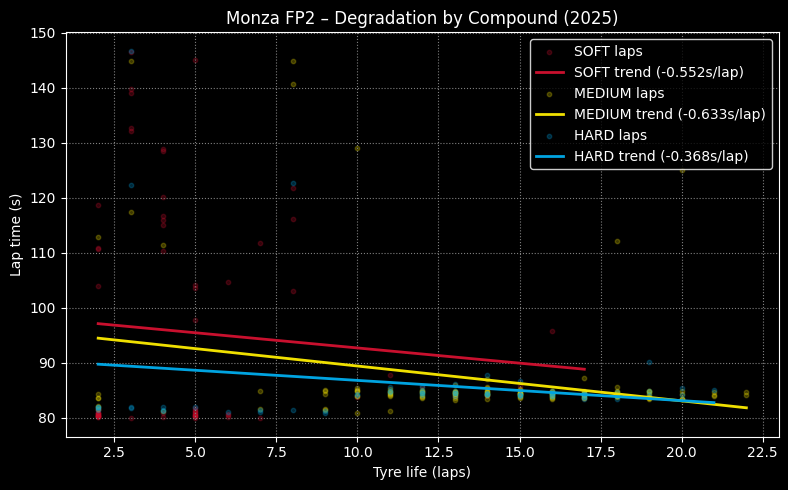

In [4]:
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os

# Enable cache
if not os.path.exists('cache'):
    os.makedirs('cache')
fastf1.Cache.enable_cache('cache')

# Load 2025 Monza FP2
session = fastf1.get_session(2025, 'Italian Grand Prix', 'FP2')
session.load()

# Convert timedelta -> seconds
def to_secs(td):
    return td.total_seconds() if pd.notnull(td) else np.nan

# ---------- Build FP2 dataset ----------
laps = session.laps.copy()
laps = laps[
    (laps['IsAccurate']) &
    (laps['PitInTime'].isna()) & (laps['PitOutTime'].isna()) &
    (laps['Compound'].notna()) & (laps['TyreLife'].notna())
].copy()

# Remove outliers using IQR per driver+compound
def iqr_filter(df, col='LapTime'):
    x = df[col].dt.total_seconds()
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    return df[(x >= q1 - 1.5*iqr) & (x <= q3 + 1.5*iqr)]

laps = laps.groupby(['Driver','Compound'], group_keys=False).apply(iqr_filter)

# ---------- Fit degradation models ----------
def fit_deg(df):
    rows = []
    for comp, d in df.groupby('Compound'):
        X = d['TyreLife'].to_numpy().reshape(-1,1)
        y = d['LapTime'].dt.total_seconds().to_numpy()
        if len(d) < 8:  # skip if not enough data
            continue
        model = LinearRegression().fit(X, y)
        slope = model.coef_[0]   # seconds per lap degradation
        intercept = model.intercept_
        rows.append({'Compound': comp, 'slope': slope, 'intercept': intercept})
    return pd.DataFrame(rows)

deg = fit_deg(laps)

# ---------- Plot ----------
plt.figure(figsize=(8,5), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

colors = {'SOFT': '#C8102E', 'MEDIUM': '#F0E000', 'HARD': '#00A3E0'}

for comp, color in colors.items():
    d = laps[laps['Compound'] == comp]
    if d.empty:
        continue

    # Scatter
    ax.scatter(d['TyreLife'], d['LapTime'].dt.total_seconds(),
               s=10, alpha=0.25, label=f"{comp} laps", color=color)

    # Regression line
    row = deg[deg['Compound'] == comp]
    if not row.empty:
        xx = np.linspace(d['TyreLife'].min(), d['TyreLife'].max(), 100)
        yy = row['intercept'].iloc[0] + row['slope'].iloc[0]*xx
        ax.plot(xx, yy, linewidth=2, color=color,
                label=f"{comp} trend ({row['slope'].iloc[0]:+.3f}s/lap)")

ax.set_title("Monza FP2 – Degradation by Compound (2025)", color='white')
ax.set_xlabel("Tyre life (laps)", color='white')
ax.set_ylabel("Lap time (s)", color='white')
ax.tick_params(colors='white')
[sp.set_color('white') for sp in ax.spines.values()]
ax.legend(facecolor='black', edgecolor='white', labelcolor='white')
ax.grid(True, color='gray', linestyle='dotted')

plt.tight_layout()
plt.show()


core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Italian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	No cached data found for lap_count. Loading data...
INFO:fastf1.fastf1.req:No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
INFO:fastf1.api:Fetching lap count data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Lo

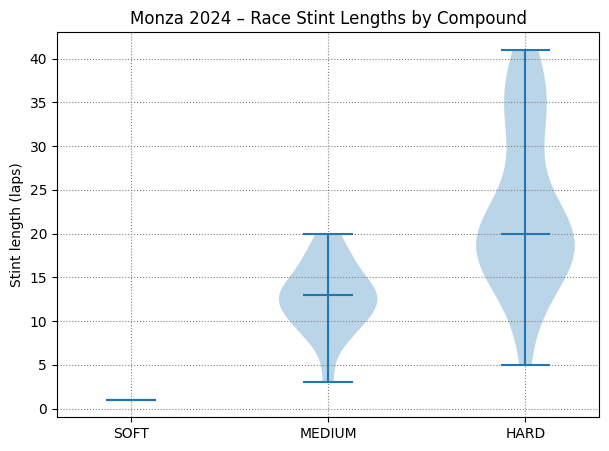

/tmp/ipython-input-694115612.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  laps_fp2 = laps_fp2.groupby(['Driver','Compound'], group_keys=False).apply(iqr_filter)


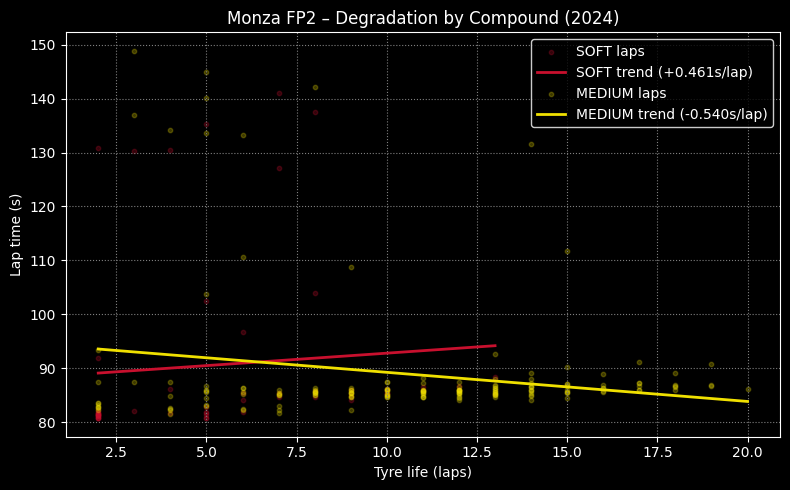

In [6]:
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os

#Cache
if not os.path.exists('cache'):
    os.makedirs('cache')
fastf1.Cache.enable_cache('cache')

#Load sessions (2024 Monza)
session_race = fastf1.get_session(2024, 'Italian Grand Prix', 'R')
session_race.load()

session_fp2 = fastf1.get_session(2024, 'Italian Grand Prix', 'FP2')
session_fp2.load()

def to_secs(td):
    return td.total_seconds() if pd.notnull(td) else np.nan

#RACE DATA (for stint lengths violin)
laps_r = session_race.laps.copy()
laps_r['LapTime_s'] = laps_r['LapTime'].apply(to_secs)
laps_r = laps_r[
    (laps_r['IsAccurate']) &
    (laps_r['PitInTime'].isna()) & (laps_r['PitOutTime'].isna())
].copy()

# Build stints
stints = (
    laps_r[['Driver','Stint','Compound','LapNumber']]
    .dropna()
    .drop_duplicates(['Driver','Stint'])
    .merge(
        laps_r.groupby(['Driver','Stint']).size().rename('StintLen').reset_index(),
        on=['Driver','Stint']
    )
    [['Driver','Stint','Compound','StintLen']]
)

#Violin Plot: Stint Lengths by Compound
comp_order = ['SOFT','MEDIUM','HARD']
data = [stints[stints['Compound']==c]['StintLen'] for c in comp_order]

plt.figure(figsize=(7,5))
ax = plt.gca()
ax.violinplot(data, showmedians=True)
ax.set_xticks([1,2,3])
ax.set_xticklabels(comp_order, color='black')
ax.set_ylabel("Stint length (laps)", color='black')
ax.set_title("Monza 2024 – Race Stint Lengths by Compound", color='black')
ax.tick_params(colors='black')
[sp.set_color('black') for sp in ax.spines.values()]
ax.grid(True, color='gray', linestyle='dotted')
plt.gcf().patch.set_facecolor('white')
plt.show()


# FP2 DATA (for degradation chart)
laps_fp2 = session_fp2.laps.copy()
laps_fp2 = laps_fp2[
    (laps_fp2['IsAccurate']) &
    (laps_fp2['PitInTime'].isna()) & (laps_fp2['PitOutTime'].isna()) &
    (laps_fp2['Compound'].notna()) & (laps_fp2['TyreLife'].notna())
].copy()

# Remove outliers per driver+compound (IQR)
def iqr_filter(df, col='LapTime'):
    x = df[col].dt.total_seconds()
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    return df[(x >= q1 - 1.5*iqr) & (x <= q3 + 1.5*iqr)]

laps_fp2 = laps_fp2.groupby(['Driver','Compound'], group_keys=False).apply(iqr_filter)

# Fit regression per compound
def fit_deg(df):
    rows = []
    for comp, d in df.groupby('Compound'):
        X = d['TyreLife'].to_numpy().reshape(-1,1)
        y = d['LapTime'].dt.total_seconds().to_numpy()
        if len(d) < 8:
            continue
        model = LinearRegression().fit(X, y)
        rows.append({'Compound': comp,
                     'slope': model.coef_[0],
                     'intercept': model.intercept_})
    return pd.DataFrame(rows)

deg = fit_deg(laps_fp2)

#FP2 Degradation Plot
plt.figure(figsize=(8,5), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

colors = {'SOFT': '#C8102E', 'MEDIUM': '#F0E000', 'HARD': '#00A3E0'}

for comp, color in colors.items():
    d = laps_fp2[laps_fp2['Compound'] == comp]
    if d.empty: continue

    ax.scatter(d['TyreLife'], d['LapTime'].dt.total_seconds(),
               s=10, alpha=0.25, label=f"{comp} laps", color=color)

    row = deg[deg['Compound'] == comp]
    if not row.empty:
        xx = np.linspace(d['TyreLife'].min(), d['TyreLife'].max(), 100)
        yy = row['intercept'].iloc[0] + row['slope'].iloc[0]*xx
        ax.plot(xx, yy, linewidth=2, color=color,
                label=f"{comp} trend ({row['slope'].iloc[0]:+.3f}s/lap)")

ax.set_title("Monza FP2 – Degradation by Compound (2024)", color='white')
ax.set_xlabel("Tyre life (laps)", color='white')
ax.set_ylabel("Lap time (s)", color='white')
ax.tick_params(colors='white')
[sp.set_color('white') for sp in ax.spines.values()]
ax.legend(facecolor='black', edgecolor='white', labelcolor='white')
ax.grid(True, color='gray', linestyle='dotted')

plt.tight_layout()
plt.show()
